IMPORTING LIBRARIES AND LOADING DIABETES DATA

In [1]:
import pickle
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_csv("../data/diabetes/patients.csv")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


FEATURE ENGINEERING

In [3]:
# dataset shape : number of records x number of features
print(df.shape)

# checking for null values:
print(df.isnull().values.any())

(768, 9)
False


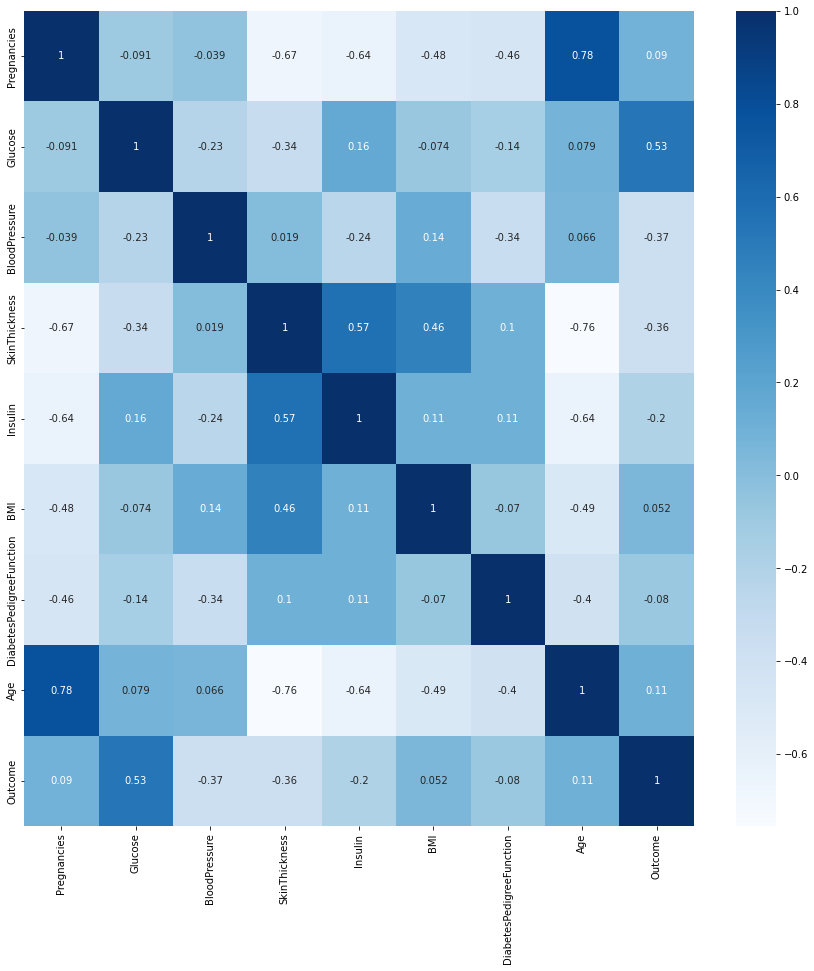

In [4]:
# correlation
corr_mat = df.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(15, 15))
g = sns.heatmap(corr_mat[top_corr_features].corr(), annot=True, cmap="Blues")

In [5]:
diabetes_true_count = len(df.loc[df['Outcome'] == 1])
diabetes_false_count = len(df.loc[df['Outcome'] == 0])

In [6]:
print("Data having 1 as output: {}".format(diabetes_true_count))
print("Data having 0 as output: {}".format(diabetes_false_count))

Data having 1 as output: 268
Data having 0 as output: 500


FEATURE SELECTION BASED ON CORRELATION AND LATER BY RANDOM FOREST FEATURE IMPORTANCE

In [7]:
selected_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
       
output_class = ['Outcome']

In [8]:
# converting from df to np array
X = df[selected_features].values
y = df[output_class].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# checking values which are 0:
print("total number of rows : {0}".format(len(df)))
print("number of rows missing Glucose: {0}".format(len(df.loc[df['Glucose'] == 0])))
print("number of rows missing BloodPressure: {0}".format(len(df.loc[df['BloodPressure'] == 0])))
print("number of rows missing insulin: {0}".format(len(df.loc[df['Insulin'] == 0])))
print("number of rows missing bmi: {0}".format(len(df.loc[df['BMI'] == 0])))
print("number of rows missing DiabetesPedigreeFunction: {0}".format(len(df.loc[df['DiabetesPedigreeFunction'] == 0])))
print("number of rows missing age: {0}".format(len(df.loc[df['Age'] == 0])))
print("number of rows missing SkinThickness: {0}".format(len(df.loc[df['SkinThickness'] == 0])))

total number of rows : 768
number of rows missing Glucose: 5
number of rows missing BloodPressure: 35
number of rows missing insulin: 374
number of rows missing bmi: 11
number of rows missing DiabetesPedigreeFunction: 0
number of rows missing age: 0
number of rows missing SkinThickness: 227


In [11]:
# imputing these missing/zero values

missing_values_imputer = SimpleImputer(missing_values=0, strategy='mean')

X_train = missing_values_imputer.fit_transform(X_train)
X_test = missing_values_imputer.fit_transform(X_test)

In [12]:
X_train.shape, X_test.shape

((614, 8), (154, 8))

APPLYING MACHINE LEARNING ALGORITHM

In [13]:
# using random forest classifier
rfc = RandomForestClassifier(random_state=10) # ravel : from (n,m) => (n,)
rfc.fit(X_train, y_train.ravel())

RandomForestClassifier(random_state=10)

In [14]:
# random forest classifier accuracy:
y_preds = rfc.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 76.62%


RANDOM FOREST FEATURE IMPORTANCE FOR FEATURE SELECTION

In [15]:
f_importance = rfc.feature_importances_

final_features = sorted(f_importance)

for i, v in enumerate(f_importance):
    print('{}, Score: {:.5f}'.format(selected_features[i], v))

print(final_features)

final_selected_features = ['Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Pregnancies, Score: 0.07289
Glucose, Score: 0.25689
BloodPressure, Score: 0.08124
SkinThickness, Score: 0.07160
Insulin, Score: 0.08840
BMI, Score: 0.17126
DiabetesPedigreeFunction, Score: 0.11887
Age, Score: 0.13883
[0.07160462271898341, 0.07289386386436586, 0.08124372628452486, 0.08839786640334614, 0.11887346883040859, 0.13882951767058083, 0.1712646791944967, 0.2568922550332937]


In [16]:
X_new = df[final_selected_features].values

X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [17]:
X_train_new = missing_values_imputer.fit_transform(X_train_new)
X_test_new = missing_values_imputer.fit_transform(X_test_new)

In [18]:
rfc.fit(X_train_new, y_train.ravel())

# random forest classifier accuracy after feature importance:
y_preds_new = rfc.predict(X_test_new)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds_new)*100))

Accuracy : 71.43%


In [19]:
# using xgboost

# hyperparameter optimization

params = {
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [1, 3, 5, 7],
    "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
    "colsample_bytree" : [0.3, 0.4, 0.5, 0.7]
}

clf = xgboost.XGBClassifier()

random_search = RandomizedSearchCV(
    clf, 
    param_distributions=params, 
    n_iter=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=5, 
    verbose=3
)

random_search.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=Non

In [20]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [21]:
classifier = random_search.best_estimator_

classifier.fit(X_train, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [22]:
score = cross_val_score(classifier, X_train, y_train.ravel(), cv=10)
print(score.mean())

0.7637757800105764


In [23]:
# xgboost classifier accuracy:
y_preds = classifier.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 73.38%


In [24]:
# saving trained model
filename = '../models/diabetes_model.sav'
pickle.dump(rfc, open(filename, 'wb'))

# loading trained model
# model = pickle.load(open(filename, 'rb'))
# result = model.score(X_test, y_test)
# print(result)